In [ ]:
#used one hot encoding instead of TF-IDF (Term Frequency – Inverse Document Frequency) 
#is a text vectorization technique.
#one hot encoding has higher precision

#stemming for generalization 
#threshold value = 0.3 as it gives highest


In [26]:
# Cell 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

# Download necessary NLTK resources
# try:
#     nltk.data.find('corpora/stopwords')
# except:
#     nltk.download('stopwords', quiet=True)
#     ltk.download('punkt', quiet=True)
    
# Set plot style
plt.style.use('ggplot')

Dataset shape: (5572, 2)

First 5 rows:


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."



Class distribution:


label
ham     4825
spam     747
Name: count, dtype: int64

Percentage of spam messages: 13.41%


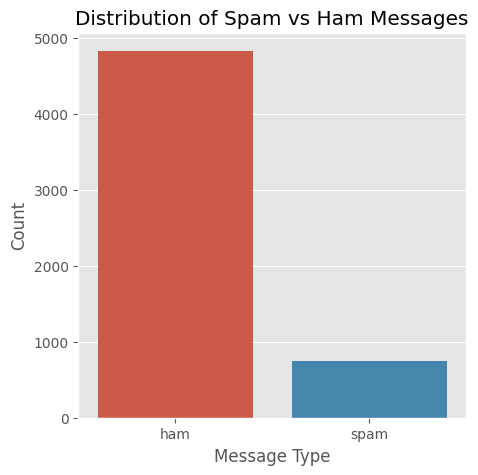

In [27]:
# Cell 2: Load and Explore Dataset
# Load dataset from the provided path
file_path = r'c:\Users\dipes\Desktop\JAVA\CODE\PYTHON\ML\spam\spam.csv'
df = pd.read_csv(file_path, encoding='latin-1')

# Keep only the first two columns (label and message)
df = df.iloc[:, :2]
df.columns = ['label', 'message']

# Display basic information
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())

# Class distribution
print("\nClass distribution:")
class_distribution = df['label'].value_counts()
display(class_distribution)
print(f"Percentage of spam messages: {class_distribution['spam']/len(df):.2%}")

# Visualize class distribution
plt.figure(figsize=(5, 5))
sns.countplot(x='label', data=df)
plt.title('Distribution of Spam vs Ham Messages')
plt.xlabel('Message Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

Message length statistics by class:


,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
ham,4825.0,71.023627,58.016023,2.0,33.0,52.0,92.0,910.0
spam,747.0,138.866131,29.183082,13.0,132.5,149.0,157.0,224.0


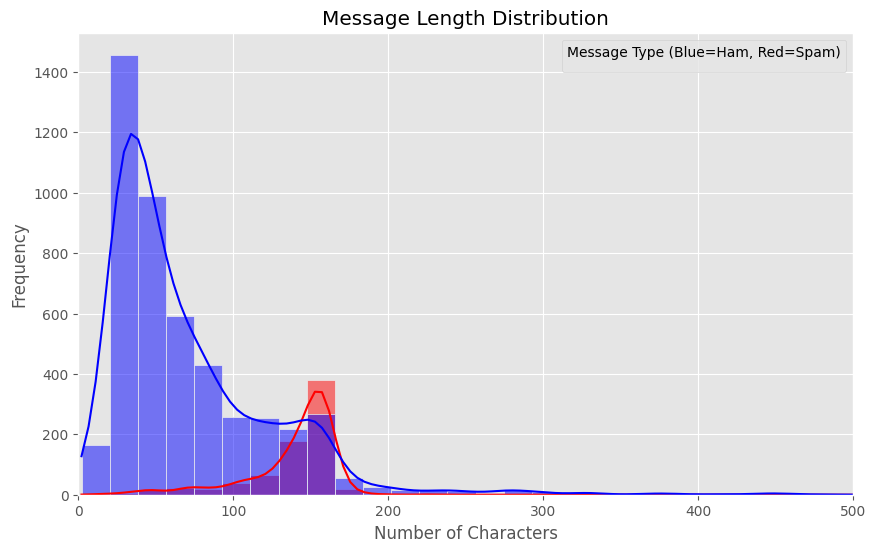

In [28]:
# # Cell 3: Data Analysis - Message Length
# # Add message length as a feature
# df['length'] = df['message'].apply(len)

# # Message length statistics by class
# print("Message length statistics by class:")
# display(df.groupby('label')['length'].describe())

# # Visualize message length distribution
# plt.figure(figsize=(10, 6))
# sns.histplot(data=df, x='length', hue='label', bins=50, kde=True)
# plt.title('Message Length Distribution')
# plt.xlabel('Number of Characters')
# plt.ylabel('Frequency')
# plt.xlim(0, 500)  # Focus on most common message lengths
# plt.legend(title='Message Type')
# plt.show()

# # Box plot of message lengths
# plt.figure(figsize=(8, 6))
# sns.boxplot(x='label', y='length', data=df)
# plt.title('Message Length by Class')
# plt.xlabel('Message Type')
# plt.ylabel('Number of Characters')
# plt.show()

# Cell 3: Data Analysis - Message Length
# Add message length as a feature
df['length'] = df['message'].apply(len)

# Message length statistics by class
print("Message length statistics by class:")
display(df.groupby('label')['length'].describe())

# Define a consistent color palette for ham and spam
colors = {"ham": "blue", "spam": "red"}

# Visualize message length distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='length', hue='label', bins=50, kde=True, palette=colors)
plt.title('Message Length Distribution')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.xlim(0, 500)  # Focus on most common message lengths
plt.legend(title='Message Type (Blue=Ham, Red=Spam)')
plt.show()

# Box plot of message lengths
# plt.figure(figsize=(8, 6))
# sns.boxplot(x='label', y='length', data=df, palette=colors)
# plt.title('Message Length by Class')
# plt.xlabel('Message Type (Blue=Ham, Red=Spam)')
# plt.ylabel('Number of Characters')
# plt.show()

In [29]:
#normalization through stemming

# Cell 4: Text Preprocessing Function
def preprocess_text(text):
    """
    Function to preprocess text:
    1. Convert to lowercase
    2. Remove punctuation
    3. Remove numbers
    4. Remove stopwords
    5. Apply stemming
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Tokenize
    tokens = text.split()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Apply stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    
    # Join tokens back into a string
    return ' '.join(tokens)

# Apply preprocessing to messages
df['clean_message'] = df['message'].apply(preprocess_text)

# Display examples of original and preprocessed messages
print("Examples of preprocessing results:")
display(pd.DataFrame({
    'Original Message': df['message'][:5],
    'Preprocessed Message': df['clean_message'][:5]
}))

Examples of preprocessing results:


,Original Message,Preprocessed Message
0,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkt st m...
3,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say
4,"Nah I don't think he goes to usf, he lives aro...",nah dont think goe usf live around though


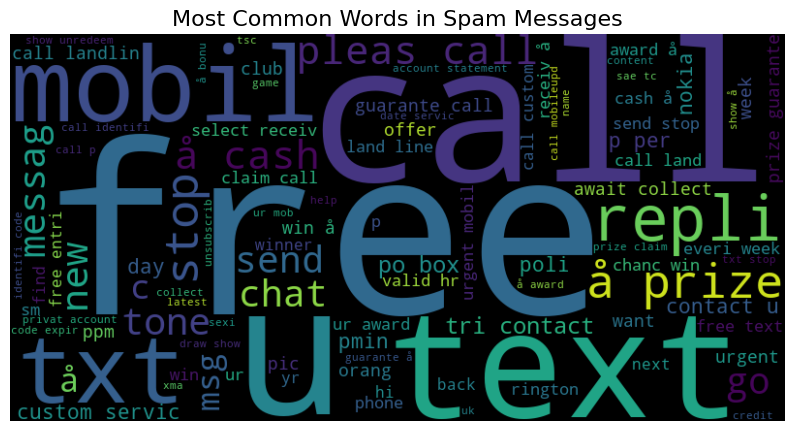

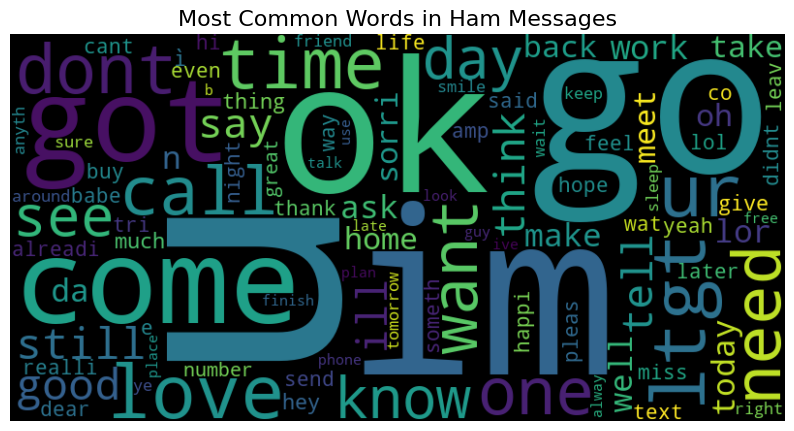

In [30]:
# Cell 5: Word Cloud Visualization
from wordcloud import WordCloud

# Create separate DataFrames for spam and ham messages
spam_messages = df[df['label'] == 'spam']['clean_message']
ham_messages = df[df['label'] == 'ham']['clean_message']

# Function to generate word cloud
def generate_wordcloud(text_series, title):
    # Combine all messages into a single string
    text = ' '.join(text_series)
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, 
                          background_color='black', 
                          max_words=100, 
                          contour_width=3, 
                          contour_color='steelblue').generate(text)
    
    # Display the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()

# Generate word clouds
try:
    generate_wordcloud(spam_messages, 'Most Common Words in Spam Messages')
    generate_wordcloud(ham_messages, 'Most Common Words in Ham Messages')
except:
    print("WordCloud package might not be installed. You can install it using: pip install wordcloud")
    print("Alternatively, you can continue without the word cloud visualization.")

In [31]:
# Cell 6: Prepare Data for Modeling
# Convert labels to binary values
df['label_binary'] = df['label'].map({'ham': 0, 'spam': 1})



# Split data into features and target
X = df['clean_message']
y = df['label_binary']

# Create train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"Spam ratio in training set: {sum(y_train)/len(y_train):.2%}")
print(f"Spam ratio in testing set: {sum(y_test)/len(y_test):.2%}")

Training set size: 4457
Testing set size: 1115
Spam ratio in training set: 13.42%
Spam ratio in testing set: 13.36%


In [13]:
# Cell 7: Feature Engineering - TF-IDF Vectorization
# Use TF-IDF vectorization to convert text to numerical features
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"Training features shape: {X_train_tfidf.shape}")
print(f"Testing features shape: {X_test_tfidf.shape}")
print(f"Number of features (words): {X_train_tfidf.shape[1]}")

# Display the first few feature names (words)
feature_names = tfidf_vectorizer.get_feature_names_out()
print("\nSample features (words):")
print(feature_names[:20])

Training features shape: (4457, 5000)
Testing features shape: (1115, 5000)
Number of features (words): 5000

Sample features (words):
['aathilov' 'aathiwher' 'abdomen' 'abeg' 'abel' 'aberdeen' 'abi' 'abil'
 'abiola' 'abj' 'abl' 'abnorm' 'abouta' 'absenc' 'absolut' 'abstract'
 'abt' 'abta' 'aburo' 'abus']


In [32]:
# Cell 8: Feature Engineering - One-Hot Encoding (Alternative)
# One-hot encoding using CountVectorizer with binary=True
count_vectorizer = CountVectorizer(binary=True, max_features=5000)
X_train_onehot = count_vectorizer.fit_transform(X_train)
X_test_onehot = count_vectorizer.transform(X_test)

print(f"Training features shape (one-hot): {X_train_onehot.shape}")
print(f"Testing features shape (one-hot): {X_test_onehot.shape}")

# Calculate sparsity of the one-hot encoded matrix
sparsity = 1.0 - X_train_onehot.nnz / (X_train_onehot.shape[0] * X_train_onehot.shape[1])
print(f"Sparsity of one-hot encoded matrix: {sparsity:.2%}")

Training features shape (one-hot): (4457, 5000)
Testing features shape (one-hot): (1115, 5000)
Sparsity of one-hot encoded matrix: 99.84%


In [33]:
# Cell 9: Train Logistic Regression Model
# Train with TF-IDF features
tfidf_model = LogisticRegression(C=1.0, solver='liblinear', max_iter=1000, random_state=42)
tfidf_model.fit(X_train_tfidf, y_train)

# Train with one-hot encoding
onehot_model = LogisticRegression(C=1.0, solver='liblinear', max_iter=1000, random_state=42)
onehot_model.fit(X_train_onehot, y_train)

print("Models trained successfully!")

Models trained successfully!


In [16]:
# Cell 10: Model Evaluation
# Predictions with TF-IDF model
y_pred_tfidf = tfidf_model.predict(X_test_tfidf)
y_prob_tfidf = tfidf_model.predict_proba(X_test_tfidf)[:, 1]  # Probability of spam

# Predictions with one-hot model
y_pred_onehot = onehot_model.predict(X_test_onehot)
y_prob_onehot = onehot_model.predict_proba(X_test_onehot)[:, 1]

# Classification report for TF-IDF model
print("Classification Report (TF-IDF Model):")
print(classification_report(y_test, y_pred_tfidf))

# Classification report for one-hot model
print("\nClassification Report (One-Hot Encoding Model):")
print(classification_report(y_test, y_pred_onehot))

Classification Report (TF-IDF Model):
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       966
           1       0.99      0.75      0.85       149

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.96      1115


Classification Report (One-Hot Encoding Model):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       1.00      0.85      0.92       149

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115



TF-IDF Model Performance:


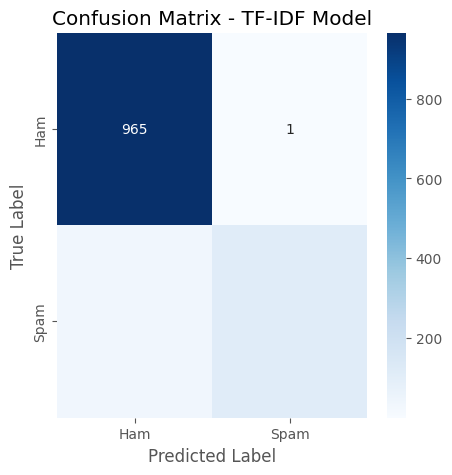

Accuracy: 0.9659
Precision: 0.9912
Recall: 0.7517
Specificity: 0.9990
F1 Score: 0.8550

One-Hot Encoding Model Performance:


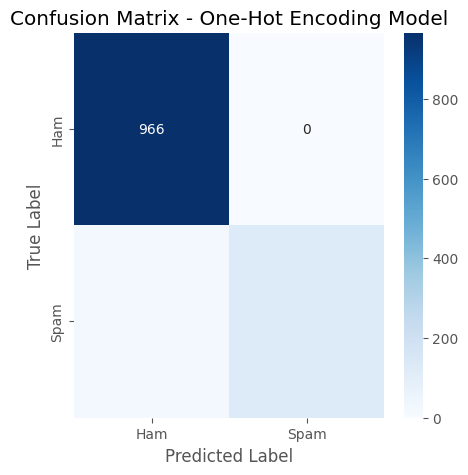

Accuracy: 0.9803
Precision: 1.0000
Recall: 0.8523
Specificity: 1.0000
F1 Score: 0.9203


In [34]:
# Cell 11: Confusion Matrix Visualization
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Ham', 'Spam'], 
                yticklabels=['Ham', 'Spam'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()
    
    # Calculate metrics
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Plot confusion matrices
print("TF-IDF Model Performance:")
plot_confusion_matrix(y_test, y_pred_tfidf, 'Confusion Matrix - TF-IDF Model')

print("\nOne-Hot Encoding Model Performance:")
plot_confusion_matrix(y_test, y_pred_onehot, 'Confusion Matrix - One-Hot Encoding Model')

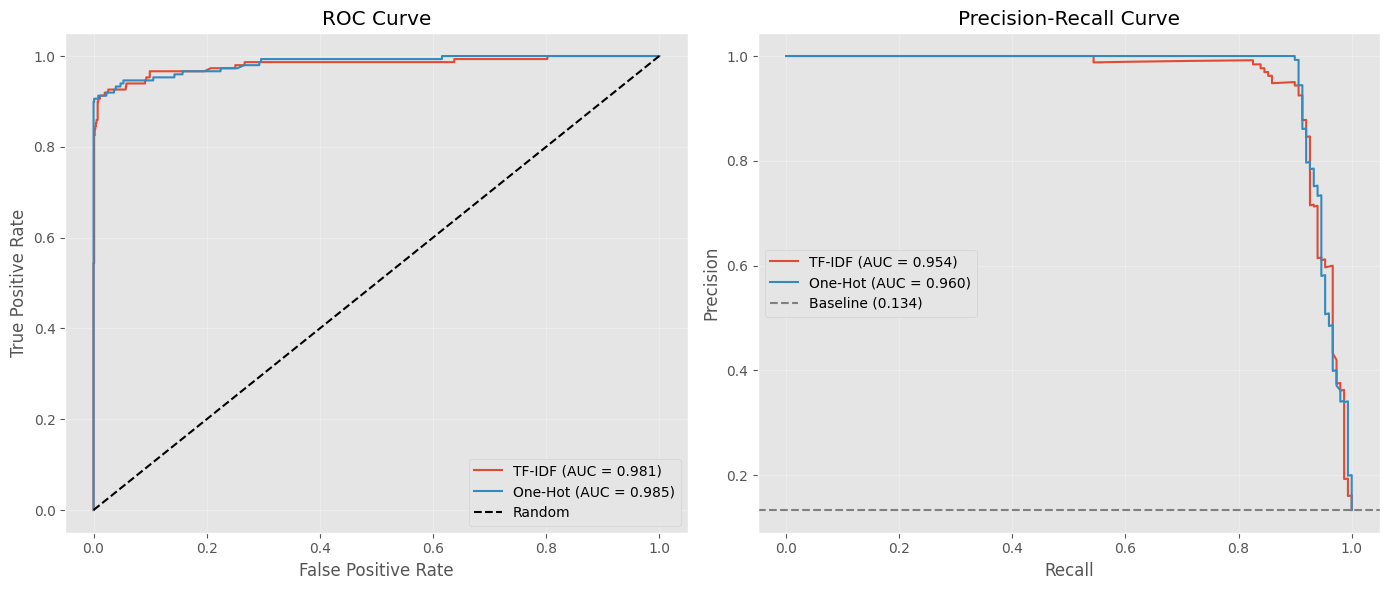

In [18]:
# Cell 12: ROC and Precision-Recall Curves
# Plot ROC and Precision-Recall curves
plt.figure(figsize=(14, 6))

# ROC Curve
plt.subplot(1, 2, 1)
# TF-IDF model
fpr_tfidf, tpr_tfidf, _ = roc_curve(y_test, y_prob_tfidf)
roc_auc_tfidf = auc(fpr_tfidf, tpr_tfidf)
plt.plot(fpr_tfidf, tpr_tfidf, label=f'TF-IDF (AUC = {roc_auc_tfidf:.3f})')

# One-hot model
fpr_onehot, tpr_onehot, _ = roc_curve(y_test, y_prob_onehot)
roc_auc_onehot = auc(fpr_onehot, tpr_onehot)
plt.plot(fpr_onehot, tpr_onehot, label=f'One-Hot (AUC = {roc_auc_onehot:.3f})')

# Random classifier
plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True, alpha=0.3)

# Precision-Recall Curve
plt.subplot(1, 2, 2)
# TF-IDF model
precision_tfidf, recall_tfidf, _ = precision_recall_curve(y_test, y_prob_tfidf)

#AREA UNDER CURVE
pr_auc_tfidf = auc(recall_tfidf, precision_tfidf)

plt.plot(recall_tfidf, precision_tfidf, label=f'TF-IDF (AUC = {pr_auc_tfidf:.3f})')

# One-hot model
precision_onehot, recall_onehot, _ = precision_recall_curve(y_test, y_prob_onehot)
pr_auc_onehot = auc(recall_onehot, precision_onehot)
plt.plot(recall_onehot, precision_onehot, label=f'One-Hot (AUC = {pr_auc_onehot:.3f})')

# Baseline
plt.axhline(y=sum(y_test)/len(y_test), linestyle='--', color='gray', 
            label=f'Baseline ({sum(y_test)/len(y_test):.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Top 10 most important words for classification:


,Feature,Coefficient,Abs_Coefficient
4669,txt,5.298155,5.298155
477,claim,3.698728,3.698728
3841,repli,3.381765,3.381765
4429,stop,3.369710,3.369710
380,call,3.331097,3.331097
1324,free,3.298942,3.298942
4551,text,3.238438,3.238438
4102,servic,3.233384,3.233384
2787,mobil,3.179057,3.179057
3606,prize,2.796177,2.796177


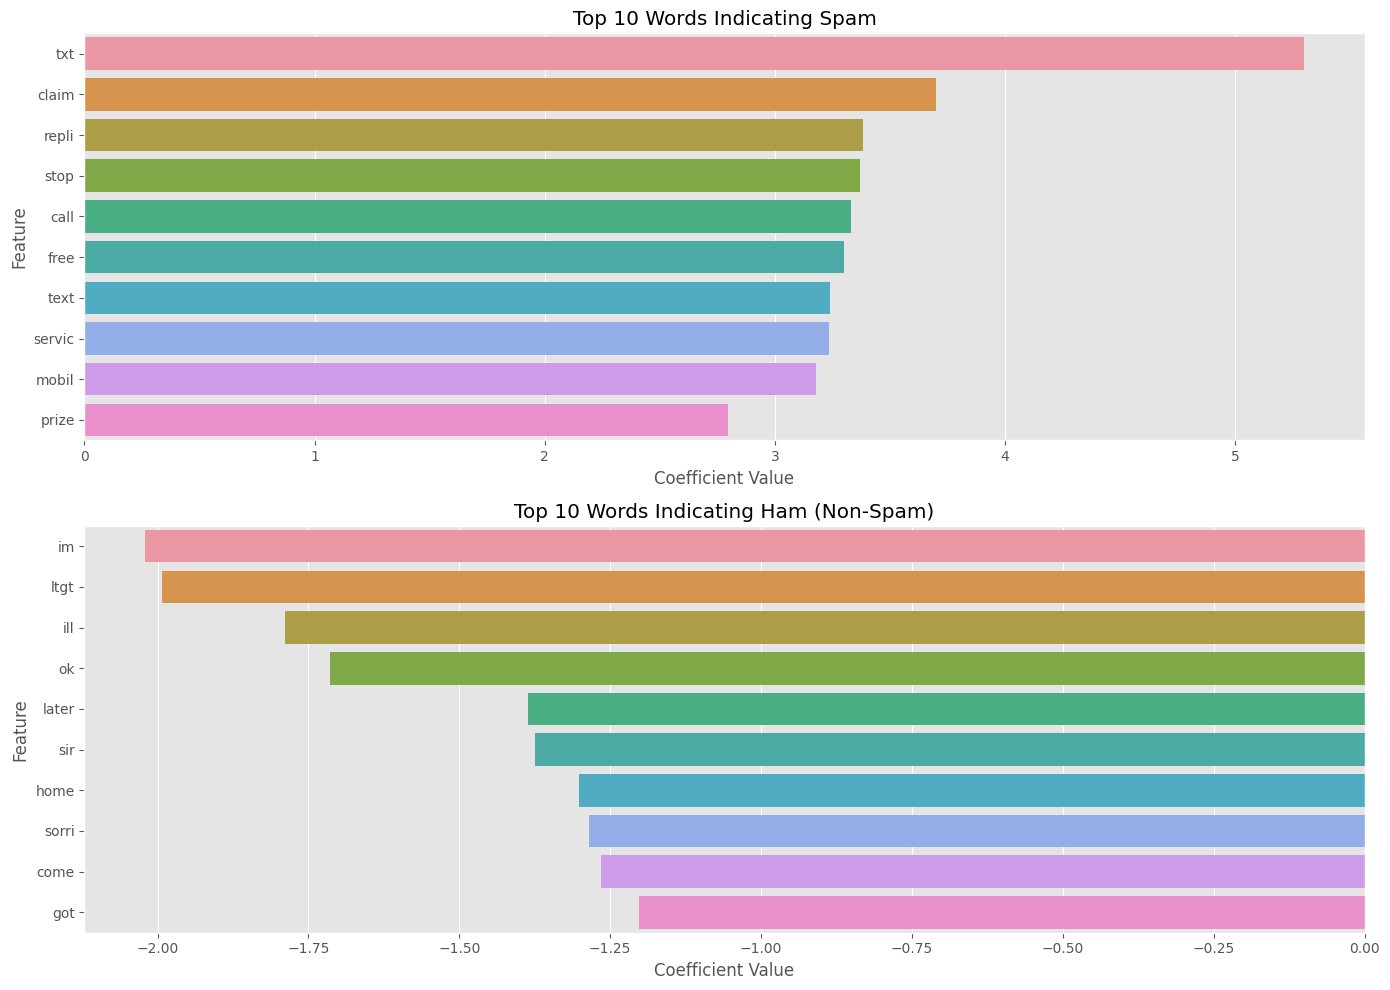

In [46]:
# Cell 13: Feature Importance Analysis
# Get coefficients from the TF-IDF model
coefficients = tfidf_model.coef_[0]

# Create a DataFrame with features and their coefficients
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort by absolute coefficient value
feature_importance['Abs_Coefficient'] = abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

# Display top 10 most important features
print("Top 10 most important words for classification:")
display(feature_importance.head(10))

# Plot top positive and negative coefficients
plt.figure(figsize=(14, 10))

# Top positive coefficients (spam indicators)
plt.subplot(2, 1, 1)
top_positive = feature_importance[feature_importance['Coefficient'] > 0].head(10)
sns.barplot(x='Coefficient', y='Feature', data=top_positive)
plt.title('Top 10 Words Indicating Spam')
plt.xlabel('Coefficient Value')

# Top negative coefficients (ham indicators)
plt.subplot(2, 1, 2)
top_negative = feature_importance[feature_importance['Coefficient'] < 0].head(10)
sns.barplot(x='Coefficient', y='Feature', data=top_negative)
plt.title('Top 10 Words Indicating Ham (Non-Spam)')
plt.xlabel('Coefficient Value')

plt.tight_layout()
plt.show()

In [48]:
# Cell 14: Test on Custom Messages
def predict_message(message, vectorizer=count_vectorizer, model=onehot_model,threshold=0.3):
    """Function to predict if a message is spam or ham"""
    # Preprocess the message
    clean_message = preprocess_text(message)
    
    # Vectorize using the trained onehot
    message_vec = vectorizer.transform([clean_message])
    
    # Predict
    prediction = model.predict(message_vec)[0]
    probability = model.predict_proba(message_vec)[0][1]
    
    return {
        "message": message,
        "prediction": "SPAM" if prediction == 1 else "HAM",
        "spam_probability": probability
    }

# Test with some example messages
test_messages = [
    "Congratulations! You've won a $1000 gift card. Call now to claim!",
    "Hey, what time are we meeting for dinner tonight?",
    "URGENT: Your bank account has been suspended. Click here to verify.",
    "I'll be there in 10 minutes, see you soon!",
    "FREE VIAGRA for all orders today only! Special discount code inside.",
    "Your package has been delivered. Click here to track: http://bit.ly/2x4Tcm",
    "Mom, can you pick me up after school today?"
]

# Create a table of predictions
results = []
for message in test_messages:
    result = predict_message(message)
    results.append(result)

results_df = pd.DataFrame(results)
results_df['spam_probability'] = results_df['spam_probability'].apply(lambda x: f"{x:.2%}")
display(results_df)

,message,prediction,spam_probability
0,Congratulations! You've won a $1000 gift card....,SPAM,66.93%
1,"Hey, what time are we meeting for dinner tonight?",HAM,0.34%
2,URGENT: Your bank account has been suspended. ...,HAM,17.36%
3,"I'll be there in 10 minutes, see you soon!",HAM,0.58%
4,FREE VIAGRA for all orders today only! Special...,HAM,39.95%
5,Your package has been delivered. Click here to...,HAM,2.13%
6,"Mom, can you pick me up after school today?",HAM,0.63%


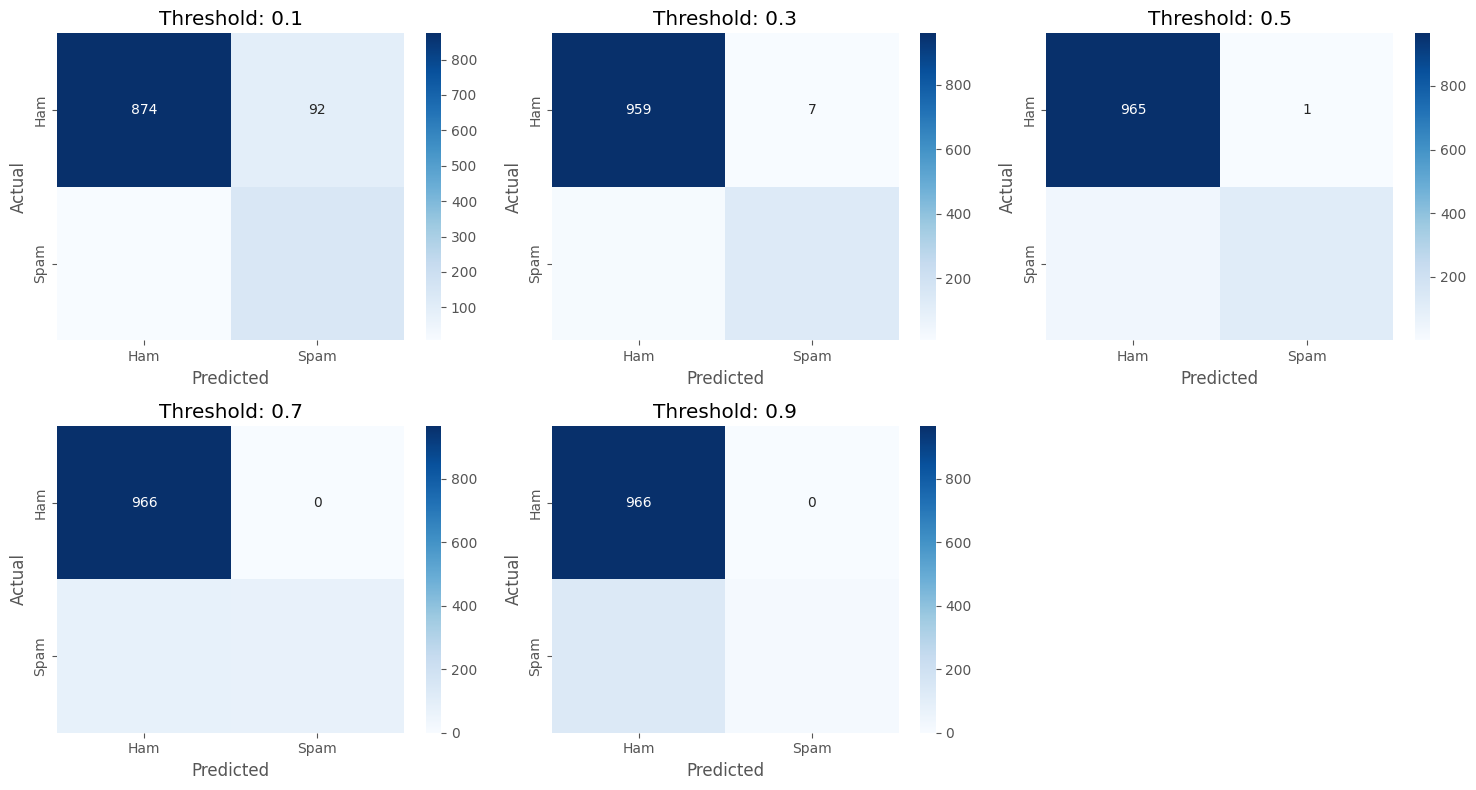

,Threshold,Accuracy,Precision,Recall,Specificity,F1 Score
0,0.1,0.911211,0.606838,0.953020,0.904762,0.741514
1,0.3,0.978475,0.949640,0.885906,0.992754,0.916667
2,0.5,0.965919,0.991150,0.751678,0.998965,0.854962
3,0.7,0.930942,1.000000,0.483221,1.000000,0.651584
4,0.9,0.880717,1.000000,0.107383,1.000000,0.193939


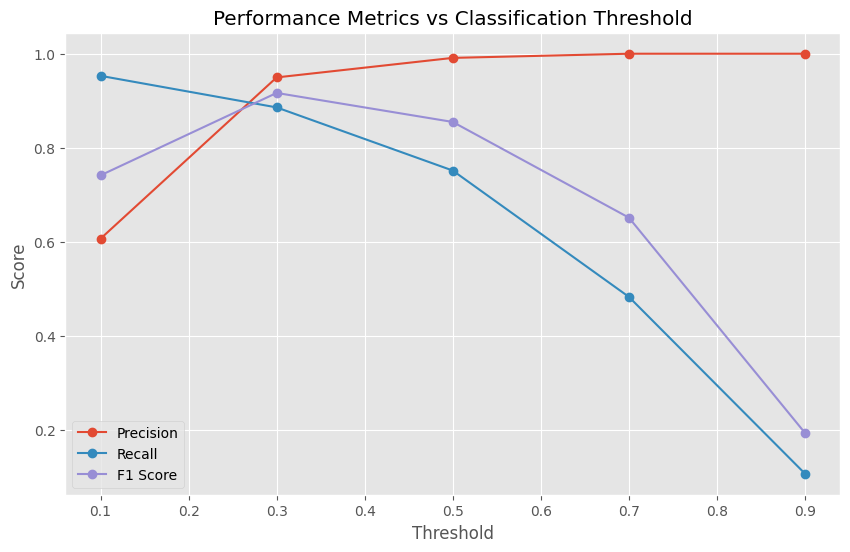

In [49]:
# Cell 15: Threshold Analysis
# Analyze different probability thresholds for spam classification
thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]
threshold_metrics = []

plt.figure(figsize=(15, 8))

for i, threshold in enumerate(thresholds):
    # Apply threshold to predictions
    y_pred_threshold = (y_prob_tfidf >= threshold).astype(int)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred_threshold)
    
    # Calculate metrics
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    # Store metrics
    threshold_metrics.append({
        'Threshold': threshold,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'Specificity': specificity,
        'F1 Score': f1
    })
    
    # Plot confusion matrix
    plt.subplot(2, 3, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Ham', 'Spam'], 
                yticklabels=['Ham', 'Spam'])
    plt.title(f'Threshold: {threshold}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Display metrics table
threshold_df = pd.DataFrame(threshold_metrics)
display(threshold_df)

# Plot metrics vs threshold
plt.figure(figsize=(10, 6))
metrics_to_plot = ['Precision', 'Recall', 'F1 Score']
for metric in metrics_to_plot:
    plt.plot(threshold_df['Threshold'], threshold_df[metric], marker='o', label=metric)

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Performance Metrics vs Classification Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [62]:
# Cell 16: SMS Spam Detector UI with Dark Theme Tabs and Tabs Below Predict Button
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import pandas as pd

# Get top 5 spam indicator features (positive coefficients)
top_spam_features = feature_importance[feature_importance['Coefficient'] > 0].head(5)

# Get top 5 ham indicator features (negative coefficients)
top_ham_features = feature_importance[feature_importance['Coefficient'] < 0].head(5)

# Get model metrics using One-Hot model (our best model)
accuracy = accuracy_score(y_test, y_pred_onehot)
cm = confusion_matrix(y_test, y_pred_onehot)
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)

# Custom CSS for styling
css = """
<style>
.header-box {
    background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
    padding: 20px;
    border-radius: 10px;
    margin-bottom: 15px;
    text-align: center;
    color: white;
}
.header-box h1 {
    margin: 0;
    padding: 0;
    color: white;
    font-size: 28px;
}
.header-box h3 {
    margin: 5px 0 0 0;
    padding: 0;
    color: rgba(255,255,255,0.8);
    font-size: 16px;
}
.dark-box {
    background-color: #222;
    color: white;
    border-radius: 8px;
    padding: 15px;
    box-shadow: 0 2px 5px rgba(0,0,0,0.3);
    margin-bottom: 15px;
}
.dark-box h3 {
    border-bottom: 2px solid #444;
    padding-bottom: 10px;
    margin-top: 0;
    color: #fff;
}
.info-box {
    background-color: white;
    border-radius: 8px;
    padding: 15px;
    box-shadow: 0 2px 5px rgba(0,0,0,0.1);
    margin-bottom: 15px;
}
.info-box h3 {
    border-bottom: 2px solid #f0f0f0;
    padding-bottom: 10px;
    margin-top: 0;
    color: #333;
}
.result-spam {
    color: #ff6b6b;
    font-weight: bold;
    font-size: 18px;
}
.result-ham {
    color: #5cb85c;
    font-weight: bold;
    font-size: 18px;
}
.dark-feature-table {
    width: 100%;
    border-collapse: collapse;
    color: white;
}
.dark-feature-table th {
    text-align: left;
    padding: 8px;
    border-bottom: 2px solid #555;
    color: #ccc;
}
.dark-feature-table td {
    padding: 8px;
    border-bottom: 1px solid #444;
    color: white;
}
.feature-table {
    width: 100%;
    border-collapse: collapse;
}
.feature-table th {
    text-align: left;
    padding: 8px;
    border-bottom: 2px solid #ddd;
    color: #333;
}
.feature-table td {
    padding: 8px;
    border-bottom: 1px solid #f0f0f0;
}
.dark-spam-feature {
    color: #ff6b6b;
    font-weight: bold;
}
.dark-ham-feature {
    color: #6bff6b;
    font-weight: bold;
}
.spam-feature {
    color: #d9534f;
    font-weight: bold;
}
.ham-feature {
    color: #5cb85c;
    font-weight: bold;
}
.dark-metric-name {
    font-weight: bold;
    color: #ddd;
}
.dark-metric-value {
    font-weight: bold;
    color: #5bc0de;
}
.metric-name {
    font-weight: bold;
    color: #555;
}
.metric-value {
    font-weight: bold;
    color: #007bff;
}
.dark-highlight {
    background-color: rgba(92, 184, 92, 0.2);
    color: #fff;
}
</style>
"""

# Header with title and subtitle
header = widgets.HTML(value=f"""
{css}
<div class="header-box">
    <h1>SMS Spam Detector</h1>
    <h3>Using Logistic Regression with One-Hot Encoding</h3>
</div>
""")

# Text area for input
text_area = widgets.Textarea(
    placeholder='Enter SMS message here...',
    description='Message:',
    rows=3,
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='100%')
)

# Threshold slider
threshold_slider = widgets.FloatSlider(
    value=0.3,
    min=0.0,
    max=1.0,
    step=0.05,
    description='Threshold:',
    disabled=False,
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='70%', margin='10px 0')
)

# Result display
result_output = widgets.Output()

# Feature importance tables - with dark theme
spam_features_html = """
<div class="dark-box">
    <h3 style="color: #ff6b6b;">Top 5 Spam Indicators</h3>
    <table class="dark-feature-table">
        <tr>
            <th>Feature</th>
            <th>Coefficient</th>
        </tr>
"""

for _, row in top_spam_features.iterrows():
    spam_features_html += f"""
        <tr>
            <td class="dark-spam-feature">{row['Feature']}</td>
            <td>{row['Coefficient']:.4f}</td>
        </tr>
    """

spam_features_html += """
    </table>
</div>
"""

ham_features_html = """
<div class="dark-box">
    <h3 style="color: #6bff6b;">Top 5 Ham Indicators</h3>
    <table class="dark-feature-table">
        <tr>
            <th>Feature</th>
            <th>Coefficient</th>
        </tr>
"""

for _, row in top_ham_features.iterrows():
    ham_features_html += f"""
        <tr>
            <td class="dark-ham-feature">{row['Feature']}</td>
            <td>{row['Coefficient']:.4f}</td>
        </tr>
    """

ham_features_html += """
    </table>
</div>
"""

features_display = widgets.HTML(value=spam_features_html + ham_features_html)

# Model metrics display - with dark theme
metrics_html = f"""
<div class="dark-box">
    <h3>Model Performance Metrics</h3>
    <table class="dark-feature-table">
        <tr>
            <td class="dark-metric-name">Accuracy:</td>
            <td class="dark-metric-value">{accuracy:.4f}</td>
        </tr>
        <tr>
            <td class="dark-metric-name">Precision:</td>
            <td class="dark-metric-value">{precision:.4f}</td>
        </tr>
        <tr>
            <td class="dark-metric-name">Recall:</td>
            <td class="dark-metric-value">{recall:.4f}</td>
        </tr>
        <tr>
            <td class="dark-metric-name">F1 Score:</td>
            <td class="dark-metric-value">{f1:.4f}</td>
        </tr>
        <tr>
            <td class="dark-metric-name">Optimal Threshold:</td>
            <td class="dark-metric-value">0.3</td>
        </tr>
    </table>
</div>
"""

confusion_matrix_html = f"""
<div class="dark-box">
    <h3>Confusion Matrix</h3>
    <p style="color:#ccc;">For One-Hot Encoding model with default threshold (0.5)</p>
    <table class="dark-feature-table" style="text-align: center;">
        <tr>
            <th></th>
            <th>Predicted Ham</th>
            <th>Predicted Spam</th>
        </tr>
        <tr>
            <td><b>Actual Ham</b></td>
            <td style="background-color: rgba(92, 184, 92, 0.3);">{tn}</td>
            <td>{fp}</td>
        </tr>
        <tr>
            <td><b>Actual Spam</b></td>
            <td>{fn}</td>
            <td style="background-color: rgba(92, 184, 92, 0.3);">{tp}</td>
        </tr>
    </table>
</div>
"""

metrics_display = widgets.HTML(value=metrics_html)
confusion_display = widgets.HTML(value=confusion_matrix_html)

# Define predict function with dark background for results
def predict_and_display(btn):
    # Get input message and threshold
    message = text_area.value
    threshold = threshold_slider.value
    
    if not message:
        with result_output:
            clear_output()
            display(HTML("<p style='color:#ff6b6b; font-weight:bold;'>Please enter a message</p>"))
        return
    
    # Preprocess message
    clean_message = preprocess_text(message)
    
    # Vectorize
    message_vec = count_vectorizer.transform([clean_message])
    
    # Get prediction probability
    probability = onehot_model.predict_proba(message_vec)[0][1]
    
    # Apply threshold
    prediction = "SPAM" if probability >= threshold else "HAM"
    
    # Check for spam features in the message
    detected_features = []
    for feature in top_spam_features['Feature']:
        if feature in clean_message.split():
            detected_features.append(feature)
    
    # Display result with dark background and white text
    with result_output:
        clear_output()
        
        result_class = "result-spam" if prediction == "SPAM" else "result-ham"
        probability_percentage = f"{probability:.2%}"
        
        result_html = f"""
        <div class="dark-box">
            <h3>Prediction Result</h3>
            <table class="dark-feature-table">
                <tr>
                    <td class="dark-metric-name">Classification:</td>
                    <td class="{result_class}">{prediction}</td>
                </tr>
                <tr>
                    <td class="dark-metric-name">Spam Probability:</td>
                    <td class="dark-metric-value">{probability_percentage}</td>
                </tr>
                <tr>
                    <td class="dark-metric-name">Using Threshold:</td>
                    <td class="dark-metric-value">{threshold}</td>
                </tr>
            </table>
        """
        
        if detected_features:
            result_html += f"""
            <p><b>Spam indicators found:</b> <span style="color: #ff6b6b; padding: 2px 0; font-weight: bold;">{', '.join(detected_features)}</span></p>
            """
        else:
            result_html += """
            <p style="color:#ccc;"><i>No known spam indicators found in message</i></p>
            """
            
        result_html += """</div>"""
        display(HTML(result_html))

# Create predict button
predict_button = widgets.Button(
    description='Predict',
    button_style='primary',
    layout=widgets.Layout(width='auto', margin='5px')
)
predict_button.on_click(predict_and_display)

# Clear button
clear_button = widgets.Button(
    description='Clear',
    button_style='danger',
    layout=widgets.Layout(width='auto', margin='5px')
)

def clear_input(btn):
    text_area.value = ''
    with result_output:
        clear_output()

clear_button.on_click(clear_input)

# Create tabs for the features panel
tab_features = widgets.Output()
with tab_features:
    display(features_display)
    
tab_metrics = widgets.Output()
with tab_metrics:
    display(metrics_display)
    
tab_confusion = widgets.Output()
with tab_confusion:
    display(confusion_display)

# Create tab widget
tabs = widgets.Tab()
tabs.children = [tab_features, tab_metrics, tab_confusion]
tabs.titles = ['Key Features', 'Model Metrics', 'Confusion Matrix']

# Set tab titles
for i, title in enumerate(['Key Features', 'Model Metrics', 'Confusion Matrix']):
    tabs.set_title(i, title)

# Layout all components
button_box = widgets.HBox([predict_button, clear_button], 
                         layout=widgets.Layout(justify_content='flex-start', margin='10px 0'))

input_section = widgets.VBox([
    widgets.HTML(value='<h3 style="margin-bottom:5px;">Test New Messages</h3>'),
    widgets.HTML(value='<p style="margin-top:0;color:#666;">Enter a message to check if it\'s spam</p>'),
    text_area, 
    threshold_slider, 
    button_box
], layout=widgets.Layout(margin='10px 0'))

results_section = widgets.VBox([result_output])

# MODIFIED LAYOUT: All content in a single column with tabs below results
main_panel = widgets.VBox([
    input_section,
    results_section,
    widgets.HTML(value='<div style="height:20px;"></div>'),  # Spacer
    widgets.HTML(value='<h3 style="margin-bottom:10px;">Model Information</h3>'),
    tabs
], layout=widgets.Layout(padding='10px', width='100%'))

# Main layout - now uses a single column instead of two panels
main_content = widgets.VBox([main_panel], 
                  layout=widgets.Layout(border='1px solid #ddd', border_radius='10px', padding='10px'))

app = widgets.VBox([header, main_content])

# Display the UI
display(app)